In [15]:
import numpy as np
import corner
import pandas as pd
import torch
from baobab.sim_utils import add_g1g2_columns
from baobab.data_augmentation.noise_lenstronomy import NoiseModelNumpy
import lenstronomy
print(lenstronomy.__path__)
import os
from baobab.data_augmentation.noise_lenstronomy import get_noise_sigma2_lenstronomy
import h0rton.tdlmc_utils as tdlmc_utils
from h0rton.configs import TrainValConfig, TestConfig
from h0rton.h0_inference import H0Posterior, plot_h0_histogram, h0_utils, plotting_utils
from h0rton.trainval_data import XYData
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Util import constants
from astropy.cosmology import FlatLambdaCDM
from  lenstronomy.Plots import lens_plot
import lenstronomy.Util.util as util
import lenstronomy.Util.simulation_util as sim_util
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Plots import plot_util
import scipy.ndimage as ndimage
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from baobab.configs import BaobabConfig

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=15)
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='large', labelsize='medium')

['/home/jwp/stage/sl/lenstronomy/lenstronomy']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Curated lens examples gallery

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 8/20/2020

__Last run:__ 11/29/2020

__Goals:__
We compare the BNN-inferred, forward modeling, and precision ceiling H0 posteriors for four hand-picked lenses. The precision ceiling corresponds to the theoretical case of a perfectly known lens model. Any difference between the BNN-inferred posterior and the precision ceiling can be attributed to the lens model constraint.

__Before_running:__
1. Train the BNN, e.g.
```bash
python h0rton/train.py experiments/v2/train_val_cfg.json
```

2. Get inference results for the trained model and the precision ceiling, e.g.
```bash
python h0rton/infer_h0_mcmc_default.py experiments/v2/mcmc_default.json
python h0rton/infer_h0_simple_mc_truth.py experiments/v0/simple_mc_default.json
```

3. Summarize the inference results, e.g.
```bash
python h0rton/summarize.py 2 mcmc_default
python h0rton/summarize.py 0 mcmc_default
```

Let's first read in some inference configs and truth metadata.

In [2]:
n_test = 200
default_version_id = 3 # 1 HST orbit
truth_version_id = 0 # precision ceiling

default_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(default_version_id)
truth_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(truth_version_id)
default_summary = pd.read_csv(os.path.join(default_version_dir, 'summary.csv'), index_col=False).iloc[:n_test]
truth_summary = pd.read_csv(os.path.join(truth_version_dir, 'summary.csv'), index_col=False).iloc[:n_test]
true_H0 = 70.0
true_Om0 = 0.3
true_cosmo = FlatLambdaCDM(H0=true_H0, Om0=true_Om0)
# Join with metadata to get n_img
test_cfg_path = os.path.join(default_version_dir, 'mcmc_default.json')
test_cfg = TestConfig.from_file(test_cfg_path)
baobab_cfg = BaobabConfig.from_file(test_cfg.data.test_baobab_cfg_path)
test_dir = baobab_cfg.out_dir
metadata_path = os.path.join(test_dir, 'metadata.csv')
meta = pd.read_csv(metadata_path, index_col=None)
meta = add_g1g2_columns(meta)
meta['id'] = meta.index
default_summary = default_summary.merge(meta, on='id', how='inner', suffixes=['', '_y'])
truth_summary = truth_summary.merge(meta, on='id', how='inner', suffixes=['', '_y'])
# For getting noise kwargs
train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)

We want to cover the whole range of H0 uncertainties, so select a lens from each quartile of H0 uncertainty.

In [3]:
pd.set_option('display.max_rows', None)
std_quantiles = np.quantile(default_summary['H0_std'].values, [0.25, 0.5, 0.75, 1])
#default_summary.sort_values('D_dt_sigma')
#default_summary.iloc[43]
#print(std_quantiles)
#np.argmin(default_summary['H0_std'].values)
example_lens_i = np.array([63, 37, 86, 43]) # IDs of four hand-picked lenses
#np.digitize(default_summary.loc[example_lens_i, 'H0_std'].values, std_quantiles, right=True)

In [4]:
def gaussian(x, mean, standard_deviation, amplitude):
    """Gaussian PDF"""
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

The below cell populates dictionaries associated with the BNN, forward modeling, and precision ceiling results.

In [7]:
# Read in D_dt_samples from D_dt_dict files
from scipy import stats

n_test = 200 # number of lenses to visualize
version_id = 3 # ID of the version folder in experiments
prec_version_id = 0 # ID of the version folder corresponding to precision ceiling
true_H0 = 70.0
true_Om0 = 0.3

version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id)
test_cfg_path = os.path.join(version_dir, 'mcmc_default.json')
test_cfg = TestConfig.from_file(test_cfg_path)
baobab_cfg = BaobabConfig.from_file(test_cfg.data.test_baobab_cfg_path)
train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)
# Read in truth metadata
metadata = pd.read_csv(os.path.join(baobab_cfg.out_dir, 'metadata.csv'), index_col=None, nrows=n_test)
# Read in summary
summary = pd.read_csv(os.path.join(version_dir, 'summary.csv'), index_col=None, nrows=n_test)

ceiling_dir = os.path.join('/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(0), 'simple_mc_default')
samples_dir = os.path.join(version_dir, 'mcmc_default')
D_dt_dict_fnames = ['D_dt_dict_{0:04d}.npy'.format(lens_i) for lens_i in example_lens_i]
oversampling = 20

ceiling_samples_dict = {} # time delay precision ceiling
ceiling_weights_dict = {} # time delay precision ceiling
H0_samples_dict = {} # BNN-inferred H0 posterior
fm_samples_dict = {} # forward modeling H0 posterior

for i, lens_i in enumerate(example_lens_i):
    truth_i = summary.iloc[lens_i]
    # Populate ceiling dict
    f_name_ceiling = 'h0_dict_{0:04d}.npy'.format(lens_i)
    ceiling_dict = np.load(os.path.join(ceiling_dir, f_name_ceiling), allow_pickle=True).item()
    ceiling_samples_dict[lens_i] = ceiling_dict['h0_samples']
    ceiling_weights_dict[lens_i] = ceiling_dict['h0_weights']
    # Populate BNN dict
    f_name = 'D_dt_dict_{0:04d}.npy'.format(lens_i)
    uncorrected_D_dt_samples = np.load(os.path.join(samples_dir, f_name), allow_pickle=True).item()['D_dt_samples'] # [old_n_samples,]
    # Correct D_dt samples using k_ext
    uncorrected_D_dt_samples = h0_utils.remove_outliers_from_lognormal(uncorrected_D_dt_samples, 3).reshape(-1, 1) # [n_samples, 1] 
    k_ext_rv = getattr(stats, test_cfg.kappa_ext_prior.dist)(**test_cfg.kappa_ext_prior.kwargs)
    k_ext = k_ext_rv.rvs(size=[len(uncorrected_D_dt_samples), oversampling]) # [n_samples, oversampling]
    if test_cfg.kappa_ext_prior.transformed:
        D_dt_samples = (uncorrected_D_dt_samples*k_ext).flatten()
    else:
        D_dt_samples = (uncorrected_D_dt_samples/(1.0 - k_ext)).flatten() # [n_samples,]
    # Convert D_dt into H0
    cosmo_converter = h0_utils.CosmoConverter(truth_i['z_lens'], truth_i['z_src'], H0=true_H0, Om0=true_Om0)
    H0_samples = cosmo_converter.get_H0(D_dt_samples)
    H0_samples_dict[lens_i] = H0_samples
    # Populate forward modeling dict
    version_id = 2
    fm_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(version_id)
    fm_samples_path = os.path.join(fm_version_dir, 'forward_modeling_{:d}'.format(lens_i), 'D_dt_dict_{0:04d}.npy'.format(lens_i))
    fm_D_dt_samples = np.load(fm_samples_path, allow_pickle=True).item()['D_dt_samples']
    fm_D_dt_samples = fm_D_dt_samples[int(fm_D_dt_samples.shape[0]*0.95):]
    fm_D_dt_samples *= np.random.normal(1, 0.025, fm_D_dt_samples.shape)
    fm_H0_samples = cosmo_converter.get_H0(fm_D_dt_samples)
    fm_samples_dict[lens_i] = fm_H0_samples

Note that the below cells take a while (~10 min each) to run because of the caustics computation. We enable two plots: one that includes the precision ceiling (the paper version) and the other that doesn't (talk version, to minimize confusion). The paper version first:

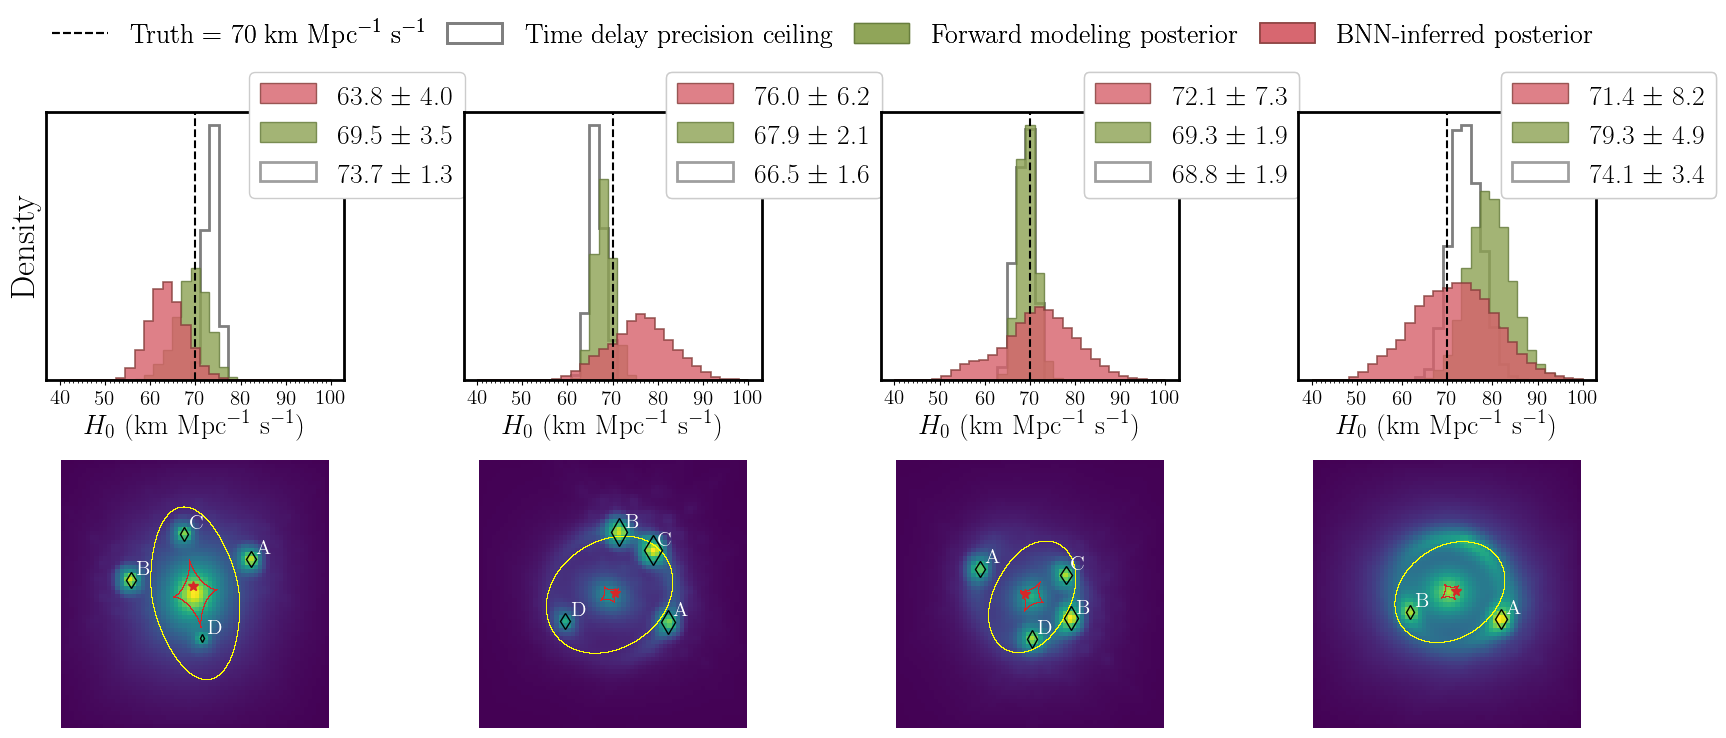

In [24]:
plt.close('all')
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))


# H0 histograms
for col_i, lens_i in enumerate(example_lens_i):
    axes[0, col_i].axvline(x=true_H0, linestyle='--', color='k', label='Truth = 70 km Mpc$^{-1}$ s$^{-1}$')
    # Plot precision floor
    truth_lens_info = truth_summary[truth_summary['id'] == lens_i].squeeze()
    truth_H0_mean = truth_lens_info['H0_mean']
    truth_H0_std = truth_lens_info['H0_std']
    amp = 1.0/truth_H0_std/np.sqrt(2*np.pi)
    popt = [truth_H0_mean, truth_H0_std, amp]
    #truth_samples = np.random.normal(truth_H0_mean, truth_H0_std, 10000)
    x_interval_for_fit = np.linspace(40, 100, 1000) 
    default_lens_info = default_summary[default_summary['id'] == lens_i].squeeze()
    default_H0_mean = default_lens_info['H0_mean']
    default_H0_std = default_lens_info['H0_std']
    default_samples = np.random.normal(default_H0_mean, default_H0_std, 10000)
    # Get max count
    counts, bins = np.histogram(H0_samples_dict[lens_i], bins=40, range=[40, 100])
    weight = np.ones_like(H0_samples_dict[lens_i])*amp/np.max(counts)
    # Plot histogram of BNN samples
    bins = np.linspace(40, 100, 30)
    n, bins, _ = axes[0, col_i].hist(ceiling_samples_dict[lens_i], 
                            weights=ceiling_weights_dict[lens_i], 
                            bins=bins, alpha=1, range=[40, 100.0], edgecolor='tab:gray',
                            histtype='step', density=True, linewidth=2,
                            label='Time delay precision ceiling') 
    
    fm_counts, fm_bins = np.histogram(fm_samples_dict[lens_i], bins=bins, range=[40, 100])
    fm_weight = np.max(n)/np.max(fm_counts)
    _ = axes[0, col_i].hist(fm_samples_dict[lens_i], 
                            #weights=np.ones_like(fm_samples_dict[lens_i])*fm_weight,
                            bins=bins, alpha=0.8, density=True, color='#8ca252', range=[40, 100.0], 
                            edgecolor='#637939', histtype='stepfilled', linewidth=1.0, 
                            label='Forward modeling posterior') 
    bnn_counts, bnn_bins = np.histogram(H0_samples_dict[lens_i], bins=bins, range=[40, 100])
    bnn_weight = np.max(n)/np.max(bnn_counts)
    _ = axes[0, col_i].hist(H0_samples_dict[lens_i], 
                            #weights=np.ones_like(H0_samples_dict[lens_i])*bnn_weight,
                            bins=bins, alpha=0.8, density=True, color='#d6616b', range=[40, 100.0], 
                            edgecolor='#843c39', histtype='stepfilled', linewidth=1.2, 
                            label='BNN-inferred posterior') 
    # Plot forward modeling
    fm_stats = h0_utils.get_normal_stats(fm_samples_dict[lens_i])
    # Plot histogram of time delay precision ceiling
    #axes[0, col_i].plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), color='tab:gray', label='Time delay precision ceiling', lw=4)
    
    axes[0, col_i].set_xticks(np.arange(40, 100 + 5, 10))
    axes[0, col_i].set_xticks(np.arange(40, 100 + 1, 1), minor=True)
    axes[0, col_i].set_yticks([])
    axes[0, col_i].set_xlabel('$H_0$ (km Mpc$^{-1}$ s$^{-1}$)', fontsize=20)
    
    subplot_legend_elements = [
                                Patch(facecolor='#d6616b', edgecolor='#843c39', alpha=0.8, label='{:0.1f} $\pm$ {:0.1f}'.format(default_H0_mean, default_H0_std)),
                              Patch(facecolor='#8ca252', edgecolor='#637939', alpha=0.8, label='{:0.1f} $\pm$ {:0.1f}'.format(fm_stats['mean'], fm_stats['std'])),
    Patch(facecolor='white', edgecolor='tab:gray', linewidth=2, alpha=0.75, label='{:0.1f} $\pm$ {:0.1f}'.format(truth_H0_mean, truth_H0_std)),]
    subplot_legend = axes[0, col_i].legend(handles=subplot_legend_elements, loc=[0.68, 0.68], framealpha=1.0, fontsize=20)
    axes[0, col_i].add_artist(subplot_legend)
    
global_legend = axes[0, 0].legend(bbox_to_anchor=(0.03, 1.23, n_cols + 1.15, 0.102), loc='upper center', ncol=4, mode="expand", borderaxespad=-0.5, fontsize=20, frameon=False)

axes[0, 0].add_artist(global_legend)
axes[0, 0].set_ylabel('Density', fontsize=25)

bp = baobab_cfg.survey_info.bandpass_list[0]
exposure_time_factor = np.ones([1, 1, 1]) 
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs = survey_object.kwargs_single_band()
# Factor of effective exptime relative to exptime of the noiseless images
exposure_time_factor[0, :, :] = train_val_cfg.data.eff_exposure_time[bp]/noise_kwargs['exposure_time']

noise_kwargs.update(exposure_time=train_val_cfg.data.eff_exposure_time[bp])
# Dictionary of noise models
noise_model = NoiseModelNumpy(**noise_kwargs)

# Noised images
for col_i, lens_i in enumerate(example_lens_i):
    lens_info = default_summary[default_summary['id'] == lens_i].squeeze()
    img = np.load(os.path.join(test_dir, 'X_{0:07d}.npy'.format(int(lens_i))))
    # Add noise
    img *= exposure_time_factor
    #noise_map = noise_model.get_noise_map(img)
    #img += noise_map
    img = np.squeeze(img)
    # Transform
    img = np.log1p(img)
    # Overlay caustic, critical curves
    lens_model = LensModel(lens_model_list=['PEMD', 'SHEAR'], cosmo=true_cosmo, z_lens=lens_info['z_lens'], z_source=lens_info['z_src'])
    kwargs_lens = [{'theta_E': lens_info['lens_mass_theta_E'], 'gamma': lens_info['lens_mass_gamma'], 'center_x': lens_info['lens_mass_center_x'], 'center_y': lens_info['lens_mass_center_y'], 'e1': lens_info['lens_mass_e1'], 'e2': lens_info['lens_mass_e2']}, {'gamma1': lens_info['external_shear_gamma1'], 'gamma2': lens_info['external_shear_gamma2']}]
    x_source = lens_info['src_light_center_x']
    y_source = lens_info['src_light_center_y']
    plotting_utils.lens_model_plot_custom(img, axes[1, col_i], lensModel=lens_model, kwargs_lens=kwargs_lens, sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True, deltaPix=0.08, numPix=64)
    axes[1, col_i].axis('off')
plt.subplots_adjust(wspace=0.4, hspace=0.3)

#fig.savefig('../curated_gallery.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [26]:
fig.savefig('../plots/curated_gallery.png', bbox_inches='tight', pad_inches=0)

And now the talk version:

In [ ]:
plt.close('all')
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))


# H0 histograms
for col_i, lens_i in enumerate(example_lens_i):
    axes[0, col_i].axvline(x=true_H0, linestyle='--', color='k', label='Truth = 70 km Mpc$^{-1}$ s$^{-1}$')
    # Plot precision floor
    truth_lens_info = truth_summary[truth_summary['id'] == lens_i].squeeze()
    truth_H0_mean = truth_lens_info['H0_mean']
    truth_H0_std = truth_lens_info['H0_std']
    amp = 1.0/truth_H0_std/np.sqrt(2*np.pi)
    popt = [truth_H0_mean, truth_H0_std, amp]
    #truth_samples = np.random.normal(truth_H0_mean, truth_H0_std, 10000)
    x_interval_for_fit = np.linspace(40, 100, 1000) 
    default_lens_info = default_summary[default_summary['id'] == lens_i].squeeze()
    default_H0_mean = default_lens_info['H0_mean']
    default_H0_std = default_lens_info['H0_std']
    default_samples = np.random.normal(default_H0_mean, default_H0_std, 10000)
    # Get max count
    counts, bins = np.histogram(H0_samples_dict[lens_i], bins=40, range=[40, 100])
    weight = np.ones_like(H0_samples_dict[lens_i])*amp/np.max(counts)
    # Plot histogram of BNN samples
    bins = np.linspace(40, 100, 30)
    #n, bins, _ = axes[0, col_i].hist(ceiling_samples_dict[lens_i], 
    #                        weights=ceiling_weights_dict[lens_i], 
    #                        bins=bins, alpha=1, range=[40, 100.0], edgecolor='tab:gray',
    #                        histtype='step', density=True, linewidth=2,
    #                        label='Time delay precision ceiling') 
    
    #fm_counts, fm_bins = np.histogram(fm_samples_dict[lens_i], bins=bins, range=[40, 100])
    #fm_weight = np.max(n)/np.max(fm_counts)
    _ = axes[0, col_i].hist(fm_samples_dict[lens_i], 
                            #weights=np.ones_like(fm_samples_dict[lens_i])*fm_weight,
                            bins=bins, alpha=0.8, density=True, color='#8ca252', range=[40, 100.0], 
                            edgecolor='#637939', histtype='stepfilled', linewidth=1.0, 
                            label='Forward modeling posterior') 
    #bnn_counts, bnn_bins = np.histogram(H0_samples_dict[lens_i], bins=bins, range=[40, 100])
    #bnn_weight = np.max(n)/np.max(bnn_counts)
    _ = axes[0, col_i].hist(H0_samples_dict[lens_i], 
                            #weights=np.ones_like(H0_samples_dict[lens_i])*bnn_weight,
                            bins=bins, alpha=0.8, density=True, color='#d6616b', range=[40, 100.0], 
                            edgecolor='#843c39', histtype='stepfilled', linewidth=1.2, 
                            label='BNN-inferred posterior') 
    # Plot forward modeling
    fm_stats = h0_utils.get_normal_stats(fm_samples_dict[lens_i])
    # Plot histogram of time delay precision ceiling
    #axes[0, col_i].plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), color='tab:gray', label='Time delay precision ceiling', lw=4)
    
    axes[0, col_i].set_xticks(np.arange(40, 100 + 5, 10))
    axes[0, col_i].set_xticks(np.arange(40, 100 + 1, 1), minor=True)
    axes[0, col_i].set_yticks([])
    axes[0, col_i].set_xlabel('$H_0$ (km Mpc$^{-1}$ s$^{-1}$)', fontsize=20)
    
    subplot_legend_elements = [
                                Patch(facecolor='#d6616b', edgecolor='#843c39', alpha=0.8, label='{:0.1f} $\pm$ {:0.1f}'.format(default_H0_mean, default_H0_std)),
                              Patch(facecolor='#8ca252', edgecolor='#637939', alpha=0.8, label='{:0.1f} $\pm$ {:0.1f}'.format(fm_stats['mean'], fm_stats['std'])),]
    #Patch(facecolor='white', edgecolor='tab:gray', linewidth=2, alpha=0.75, label='{:0.1f} $\pm$ {:0.1f}'.format(truth_H0_mean, truth_H0_std)),]
    subplot_legend = axes[0, col_i].legend(handles=subplot_legend_elements, loc=[0.68, 0.68], framealpha=1.0, fontsize=20)
    axes[0, col_i].add_artist(subplot_legend)
    
global_legend = axes[0, 0].legend(bbox_to_anchor=(0.03, 1.23, n_cols + 1.15, 0.102), loc='upper center', ncol=4, mode="expand", borderaxespad=-0.5, fontsize=20, frameon=False)

axes[0, 0].add_artist(global_legend)
axes[0, 0].set_ylabel('Density', fontsize=25)

bp = baobab_cfg.survey_info.bandpass_list[0]
exposure_time_factor = np.ones([1, 1, 1]) 
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs = survey_object.kwargs_single_band()
# Factor of effective exptime relative to exptime of the noiseless images
exposure_time_factor[0, :, :] = train_val_cfg.data.eff_exposure_time[bp]/noise_kwargs['exposure_time']

noise_kwargs.update(exposure_time=train_val_cfg.data.eff_exposure_time[bp])
# Dictionary of noise models
noise_model = NoiseModelNumpy(**noise_kwargs)

# Noised images
for col_i, lens_i in enumerate(example_lens_i):
    lens_info = default_summary[default_summary['id'] == lens_i].squeeze()
    img = np.load(os.path.join(test_dir, 'X_{0:07d}.npy'.format(int(lens_i))))
    # Add noise
    img *= exposure_time_factor
    #noise_map = noise_model.get_noise_map(img)
    #img += noise_map
    img = np.squeeze(img)
    # Transform
    img = np.log1p(img)
    # Overlay caustic, critical curves
    lens_model = LensModel(lens_model_list=['PEMD', 'SHEAR'], cosmo=true_cosmo, z_lens=lens_info['z_lens'], z_source=lens_info['z_src'])
    kwargs_lens = [{'theta_E': lens_info['lens_mass_theta_E'], 'gamma': lens_info['lens_mass_gamma'], 'center_x': lens_info['lens_mass_center_x'], 'center_y': lens_info['lens_mass_center_y'], 'e1': lens_info['lens_mass_e1'], 'e2': lens_info['lens_mass_e2']}, {'gamma1': lens_info['external_shear_gamma1'], 'gamma2': lens_info['external_shear_gamma2']}]
    x_source = lens_info['src_light_center_x']
    y_source = lens_info['src_light_center_y']
    #plotting_utils.lens_model_plot_custom(img, axes[1, col_i], lensModel=lens_model, kwargs_lens=kwargs_lens, sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True, deltaPix=0.08, numPix=64)
    axes[1, col_i].axis('off')
plt.subplots_adjust(wspace=0.4, hspace=0.3)

#fig.savefig('../curated_cwp.png', dpi=100)
plt.show()